### PPOL 564 - Coding Discussion #6<br/>Ryan Ripper<br/>11/21/21

In [1]:
# Import the necessary Python modules.

# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
# Load training data on Housing Prices in DC.
train_dat = pd.read_csv("../train_data.csv")
train_dat.shape

(43590, 39)

In [3]:
# Load test data on Housing Prices in DC.
test_dat = pd.read_csv("../test_data.csv")
test_dat.shape

(14531, 39)

<AxesSubplot:>

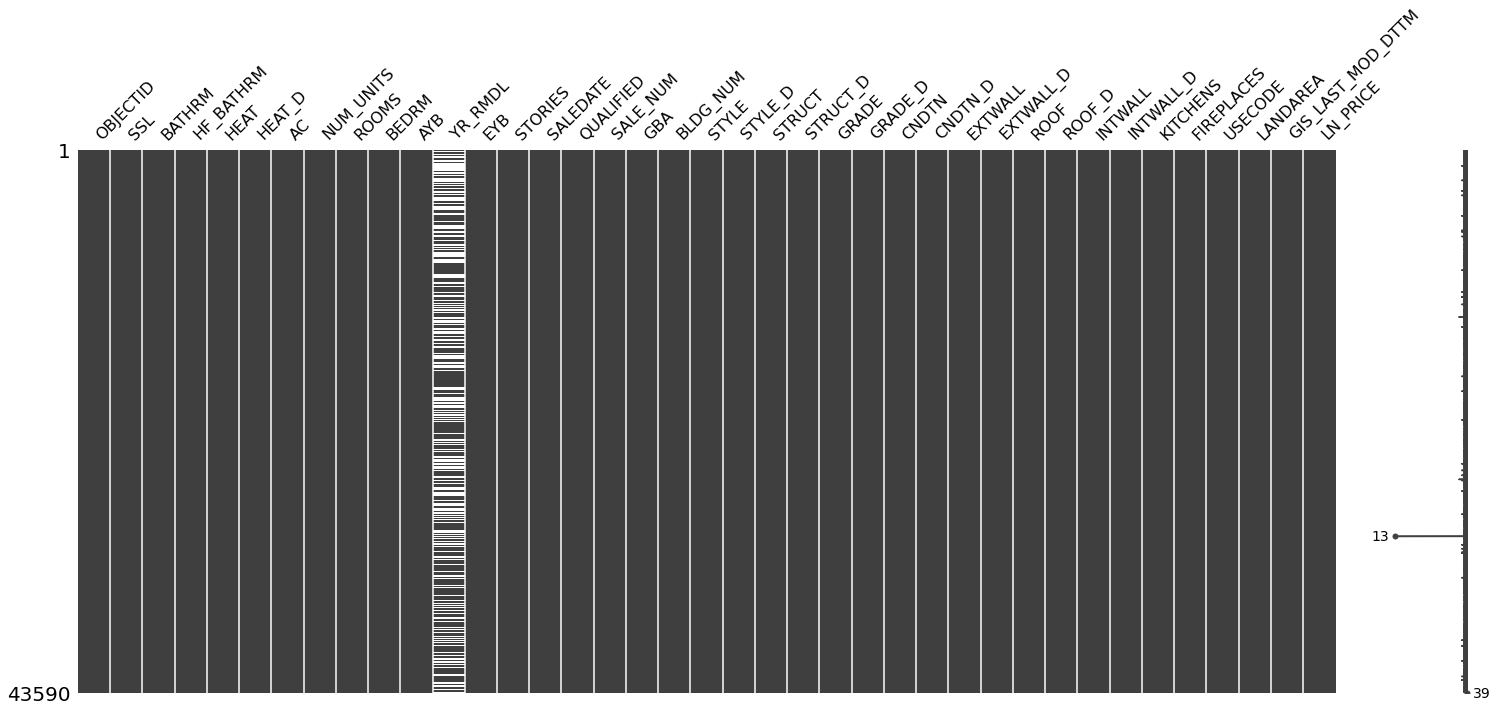

In [4]:
# Observe if we are missing any data in the training data.
miss.matrix(train_dat)

In [5]:
# Define the predictors we will use to predict the log selling price of a house in DC.
predictors = ["BATHRM", "ROOMS", "BEDRM", "GRADE", "KITCHENS"]

In [6]:
# Drop all observations where the outcome is missing for both training and test data.
# Only drop NAs for the predictors we are considering.
train_dat = train_dat.dropna(subset = predictors)
test_dat = test_dat.dropna(subset = predictors)

# Drop all observations where the outcome is missing.
train_dat = train_dat[~train_dat.LN_PRICE.isna()]
test_dat = test_dat[~test_dat.LN_PRICE.isna()]

# Only houses that are sold.
train_dat = train_dat[train_dat.LN_PRICE > 0]
test_dat = test_dat[test_dat.LN_PRICE > 0]

In [7]:
# Split the data between training and test based on the defined predictors.
y_train = train_dat.LN_PRICE
x_train = train_dat[predictors]

y_test = test_dat.LN_PRICE
x_test = test_dat[predictors]

In [8]:
# Look at the training data.
x_train.shape

(43574, 5)

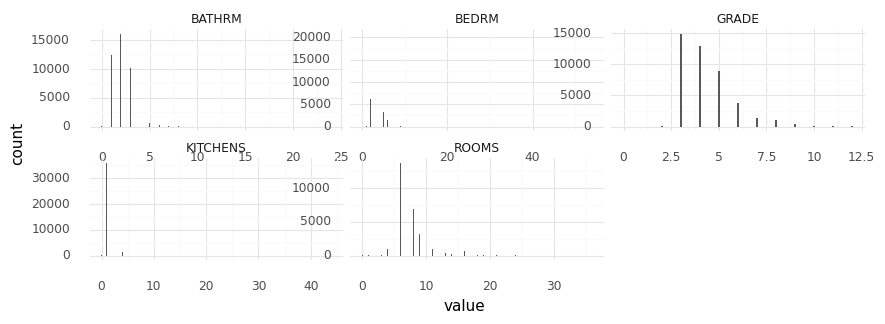

<ggplot: (8777026393338)>

In [9]:
# We explore the training data to see how the predictors are distributed.
(
    ggplot(x_train.melt(),
           aes(x = "value")) +
    geom_histogram(binwidth = 0.1) +
    facet_wrap("variable",
               scales = "free") +
    theme_minimal() +
    theme(figure_size = (10, 3))
)

When exploring the training data, we observe that when we preprocess the data we will need to scale.

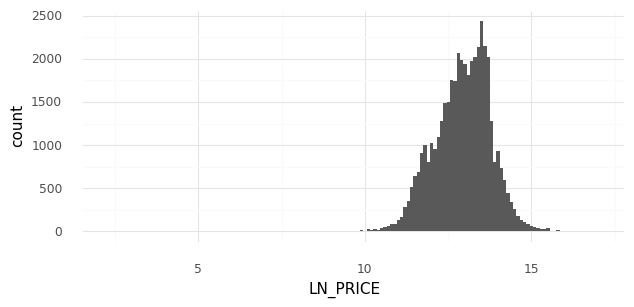

<ggplot: (8776993361631)>

In [10]:
# We explore the outcome LN_PRICE to see if there are any issues.
(
    ggplot(pd.DataFrame(dict(LN_PRICE = y_train)),
           aes(x = "LN_PRICE")) +
    geom_histogram(binwidth = 0.1) +
    theme_minimal() +
    theme(figure_size = (7, 3)) 
)

We see no observable issues with the LN_PRICE outcome data.

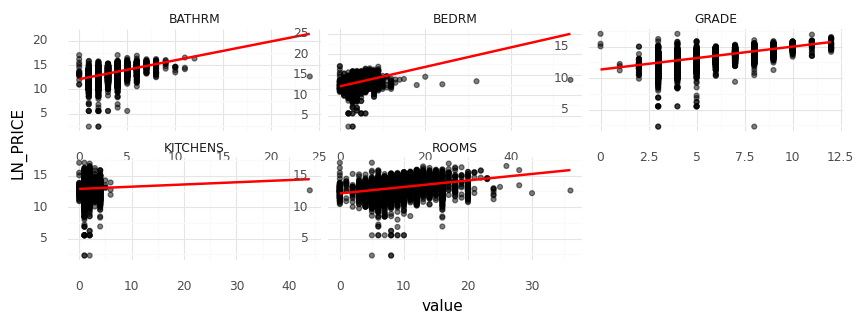

<ggplot: (8777027100151)>

In [11]:
# We explore how the predictors we have defined relate to the outcome LN_PRICE.

# First take a copy of the training data x-values.
D = x_train.copy()

# Pull in the outcomes from the training data y-values.
D["LN_PRICE"] = y_train

# We plot the predictors against the outcome LN_PRICE.
(
    ggplot(D.melt(id_vars = ["LN_PRICE"]),
           aes(x = "value",
               y = "LN_PRICE")) +
    geom_point(alpha = .5) +
    facet_wrap("variable",
               scales = "free") +
    geom_smooth(method = "lm",
                se = False,
                color = "red") +
    theme_minimal() +
    theme(figure_size = (10, 3)) 
)

We observe positive relationships between each of the chosen predictor variables and the LN_PRICE outcome variable.

In [12]:
# We set the folds index to ensure comparable samples.
fold_generator = KFold(n_splits = 5, shuffle = True, random_state = 2021)

In [13]:
# We now specify the preprocessing steps with the defined predictors from above.
preprocess = ColumnTransformer(transformers = [("num", pp.MinMaxScaler(), predictors)])

In [14]:
# We create our model pipe where we leave the model as "None" to act as a placeholder.
pipe = Pipeline(steps=[("pre_process", preprocess),
                       ("model", None)])

In [15]:
# We now specify the models we will run and their respective tuning parameters.
search_space = [
    # Linear Model
    {"model" : [LM()]},
    
    # KNN with K tuning param
    {"model" : [KNN()],
     "model__n_neighbors" : [10, 20, 40, 80, 160]},
    
    # Decision Tree with the Max Depth param
    {"model" : [DTree()],
     "model__max_depth" : [1, 2, 3, 4, 5]},
    
    # The Bagging decision tree model 
    {"model" : [Bag()]},
    
    # Random forest with the N Estimators and Max Depth tuning params
    {"model" : [RF()],
     "model__max_depth" : [1, 2, 3, 4, 5],
     "model__n_estimators" : [500, 1000, 1500, 2000]}
]

In [16]:
# We put it all together in the grid search.
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring = "neg_mean_squared_error",
                      n_jobs = 5)

In [17]:
# Fit the model to the training data.
search.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'GRADE',
                                                                          'KITCHENS'])])),
                                       ('model', None)]),
             n_jobs=5,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [10, 20, 40, 80, 160]},
             

In [18]:
# Identify the best model out of the scan.
search.best_params_

{'model': RandomForestRegressor(max_depth=5, n_estimators=2000),
 'model__max_depth': 5,
 'model__n_estimators': 2000}

In [19]:
# We use the "predict" method which uses the best model out of the scan.
y_pred = search.predict(x_test)

In [20]:
# Report the mean squared error.
m.mean_squared_error(y_test, y_pred)

0.4284368557081293

In [21]:
# Report the r-squared value.
m.r2_score(y_test, y_pred)

0.42064207635392614

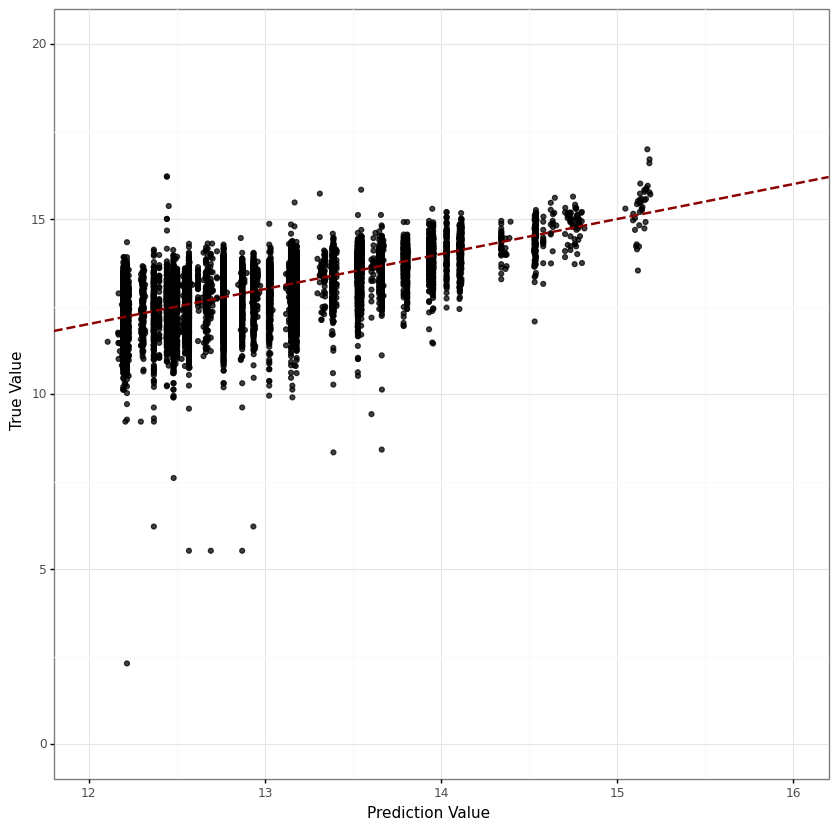

<ggplot: (8776993362107)>

In [26]:
# We plot the predicted values to the true values of LN_PRICE in order to observe how well our model performs.
(
    ggplot(pd.DataFrame(dict(pred = y_pred,
                             true = y_test)),
          aes(x = "pred",
              y = "true")) +
    xlab("Prediction Value") +
    xlim(12, 16) +
    ylim(0, 20) +
    ylab("True Value") +
    geom_point(alpha = .75) +
    geom_abline(linetype = "dashed",
                color = "darkred",
                size = 1) +
    theme_bw() +
    theme(figure_size = (10, 10))
)

The model that best fit our data with the lowest mean squared error was the Random Forest with a mixmum depth of 5 levels and 2000 estimators. It seems that the model that best fit our data was the one with the largest parameters. We observe the mean squared error dropped when compared to the example given in lecture. We also observe the R-squared value rose as the test data correlates at a higher level with the predictions as compared to the example given in lecture.